### Import the Libraries and load the Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('scaled_df.csv')
df.head()

,Magnetic core,Overall size (nm),B0 (T),Fe/cell (pg),relaxivity,target
0,1.0,0.087838,0.157734,0.042805,0.524878,0
1,1.0,0.054054,0.647779,0.018636,1.000000,1
2,1.0,0.000000,0.647779,0.013008,0.923333,1
3,1.0,0.054054,0.647779,0.015341,0.890750,1
4,1.0,0.054054,0.647779,0.014449,0.118335,1


### Drop the not important columns and Train-Test Split

In [2]:
df.drop('relaxivity', axis=1, inplace=True)
df.drop('B0 (T)', axis=1, inplace=True)
df.drop('Fe/cell (pg)', axis=1, inplace=True)
df.head()

,Magnetic core,Overall size (nm),target
0,1.0,0.087838,0
1,1.0,0.054054,1
2,1.0,0.000000,1
3,1.0,0.054054,1
4,1.0,0.054054,1


In [3]:
from Kennard_Stone import kennardstonealgorithm

In [4]:
train, test, train_labels, test_labels = kennardstonealgorithm(df,'target',5)

In [5]:
name_file = open('names.txt','r') 
names = name_file.readlines()
print('The names of the testing samples are:')
print('=====================================')
for i in test.index:
    print(names[i][:-1])

The names of the testing samples are:
Fe2O3-PLL
PDMAAm-coated-Fe2O3
iron oxide-loaded cationic nanovesicle
CMCS-SPIONs
Citrate SPION


### TPOT

Import the TPOTClassifier module and silence the warnings.

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
warnings.filterwarnings("ignore")

In [8]:
from tpot import TPOTClassifier

Run TPOT for 10 minutes with 5 individuals in each population, using all available cores in CPU, using a 3-fold cross validation to test the pipeline.

Note: Any reproduce of this step might lead to different results, as Genetic algorithms as TPOT can have differrent results in each run

In [9]:
tpot = TPOTClassifier(verbosity=0, max_time_mins=10, population_size=5,scoring='accuracy', n_jobs=-1, cv=3)
tpot.fit(train, train_labels)
print(tpot.score(test, test_labels))

c:\users\user\desktop\test-jupyter\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


1.0


In [10]:
tpot.export('SPIONs_pipeline_2_features.py')

Train and test the extracted model.

In [11]:
from sklearn.linear_model import LogisticRegression

exported_pipeline = LogisticRegression(C=40.0, dual=False, penalty="l1", random_state=42)

exported_pipeline.fit(train, train_labels);

In [12]:
print('-----------------------------------------------------------------')
print('  Sample                                    Prob(0)    Prob(1)')
print('-----------------------------------------------------------------')
for i in range(len(df)):
    print('{:40} {}'.format(names[i][:-1],exported_pipeline.predict_proba(df.drop('target',axis=1))[i]));

-----------------------------------------------------------------
  Sample                                    Prob(0)    Prob(1)
-----------------------------------------------------------------
Fe2O3-PLL                                [0.52044763 0.47955237]
uncoated                                 [0.28284178 0.71715822]
D-mannose-coated Fe2O3                   [0.07242643 0.92757357]
Fe2O3-PLL                                [0.28284178 0.71715822]
PDMAAm-coated-Fe2O3                      [0.28284178 0.71715822]
N-dodecyl-PEI2k/SPIO                     [9.99995428e-01 4.57245898e-06]
iron oxide-loaded cationic nanovesicle   [1.0000000e+00 1.9104662e-14]
iron oxide-loaded cationic nanovesicle   [1.0000000e+00 1.9104662e-14]
CMCS-SPIONs                              [9.99996032e-01 3.96829860e-06]
ED-Pullulan coating SPIO                 [9.99999998e-01 1.60250096e-09]
IONP-6PEG-HA                             [9.99999925e-01 7.50456296e-08]
PDMAAm-coated-Fe2O3NPs                   [9.99

In [13]:
test_preds = exported_pipeline.predict(test)

In [14]:
train_preds = exported_pipeline.predict(train)

#### Metrics on the Test Set 

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
print(classification_report(test_labels,test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [17]:
print(confusion_matrix(test_labels,test_preds))

[[3 0]
 [0 2]]


#### Metrics on the Train Set 

In [18]:
print(accuracy_score(test_labels,test_preds))

1.0


In [19]:
print(classification_report(train_labels,train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



In [20]:
print(confusion_matrix(train_labels,train_preds))

[[8 0]
 [0 3]]


In [21]:
print(accuracy_score(train_labels,train_preds))

1.0


### Importance of the features

In [22]:
# Get numerical feature importances
feature_list = list(test.columns)
importances = list(exported_pipeline.coef_.reshape(exported_pipeline.coef_.shape[1]))

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Coefficient: {}'.format(*pair)) for pair in feature_importances];

Variable: Magnetic core        Coefficient: 4.18
Variable: Overall size (nm)    Coefficient: -29.96


In [23]:
feature_name_for_bar = []
feature_value_for_bar = []

for i in range(len(feature_importances)):
    feature_name_for_bar.append(feature_importances[i][0])
    feature_value_for_bar.append(abs(feature_importances[i][1]))

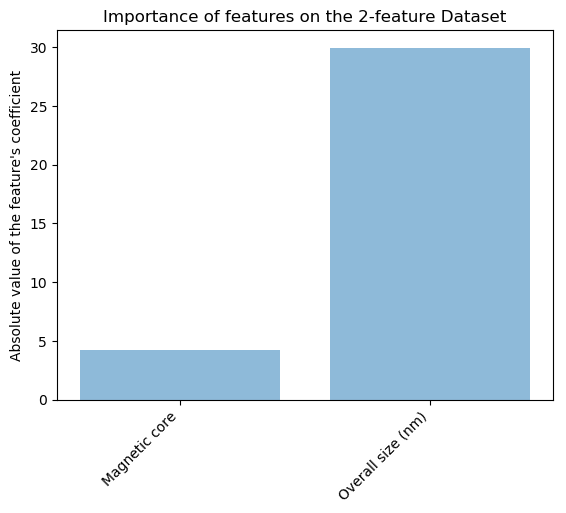

In [24]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.bar(feature_name_for_bar, feature_value_for_bar, align='center', alpha=0.5)
plt.xticks(feature_name_for_bar, feature_name_for_bar)
plt.ylabel("Absolute value of the feature's coefficient")
plt.title('Importance of features on the 2-feature Dataset')
plt.xticks(rotation=45,horizontalalignment='right')

plt.savefig('importance_2.png', bbox_inches="tight")


plt.show()

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(exported_pipeline, train, train_labels, cv=4)

In [26]:
print('Cross Validation Score: ' ,scores.mean(),'±', scores.std())

Cross Validation Score:  0.9166666666666666 ± 0.14433756729740646


### Domain of Applicability

In [27]:
test_names = [names[i] for i in test.index]

In [28]:
leverage_threshold = 3*train.shape[1]/train.shape[0]
print('The Leverage threshold is:', round(leverage_threshold, 2))

The Leverage threshold is: 0.55


In [29]:
# Labels are the values we want to predict
l_train_labels = np.array(train_labels)
l_test_labels = np.array(test_labels)
# Convert to numpy array
l_test = np.array(test)
l_train = np.array(train)

In [30]:
from numpy.linalg import matrix_power
H=list()
reliability=list()
for i in range(len(l_test)):
    H.append(l_test[i].T@(matrix_power(l_train.T@l_train, -1))@l_test[i])
    if H[i]<=leverage_threshold:
        reliability.append('reliable')
    else:
        reliability.append('unreliable')

LV = [(sample[:-1], round(l_val, 2),rely) for sample, l_val, rely in zip(test_names, H, reliability)]
for i in range(len(l_test)):
    [print('Sample: {:40} Leverage Value: {:5}    Reliability: {:20}'.format(LV[i][0],LV[i][1],LV[i][2]))];

Sample: Fe2O3-PLL                                Leverage Value:   0.2    Reliability: reliable            
Sample: PDMAAm-coated-Fe2O3                      Leverage Value:   0.2    Reliability: reliable            
Sample: iron oxide-loaded cationic nanovesicle   Leverage Value:  0.47    Reliability: reliable            
Sample: CMCS-SPIONs                              Leverage Value:  0.06    Reliability: reliable            
Sample: Citrate SPION                            Leverage Value:  0.17    Reliability: reliable            
